In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.metrics import confusion_matrix

# Common imports
import numpy as np
import os
import pandas as pd
import itertools

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from sklearn.metrics import plot_confusion_matrix

# plt.style.use(['seaborn-pastel','dark_background'])
mpl.rcParams['figure.facecolor'] = 'whitesmoke'
mpl.rcParams['axes.facecolor'] = 'white'
# mpl.rcParams['figure.figsize'] = 7, 10
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# show multiple outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# download images
import urllib.request

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "fingerprint"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

def download_fig(fig_id, fig_url, fig_extension="jpg"):
    print("Downloading", fig_url)
    req = urllib.request.Request(url)
    # Customize the default User-Agent header value:
    req.add_header('User-Agent', 'Mozilla/5.0')
    response = urllib.request.urlopen(req)
    image = response.read()
    filename = fig_id + "." + fig_extension
    with open(os.path.join(IMAGES_PATH, filename), "wb") as file:
        file.write(image)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

print("Setup finished!")

Setup finished!


In [2]:
# Download the image
# url = 'https://www.mines.edu/residence-life/wp-content/uploads/sites/46/2019/11/2-Bedroom-Units-1-112.jpg'
# download_fig('minespark', url)

In [3]:
def txtToDataFrame(file_name):
    filef = open(file_name, 'r')
    line = filef.readline()
    data_dict = {'grid_id': [], 'x': [], 'y': [], 'mac': [], 'type': [], 'rssi': []}
    grid_id = 0
    while True:
            if line.strip() is not '':
                grid_id += 1
                grid_title = line.split(' ')
                # print(grid_title)
                grid_pos = [float(grid_title[0]), float(grid_title[1])]
                for i in range(int(grid_title[2])):
                    line = filef.readline().rstrip('\n')
                    record = line.split('|')
                    ap = record[0].split(' ')
                    data_dict['grid_id'].append(grid_id)
                    data_dict['x'].append(grid_pos[0])
                    data_dict['y'].append(grid_pos[1])
                    data_dict['mac'].append(ap[0][0:17])
                    data_dict['type'].append(ap[2])
                    rssi_list = record[1].strip().split(' ') if record[1].strip() != '' else [ap[1]]
                    data_dict['rssi'].append(float(np.array(rssi_list).astype(np.float).mean()))
            line = filef.readline()
            if not line:
                break
    filef.close()
    data_frame = pd.DataFrame.from_dict(data_dict)
    return data_frame

In [4]:
def plotTrain(train_data, fig_name, width, height):
    housing_img=mpimg.imread(os.path.join(IMAGES_PATH, fig_name))
    housing_img = cv2.flip(housing_img, 0)
    train_data.plot(kind='scatter', x='x', y='y')
    plt.ylim(height, 0)
    plt.imshow(housing_img, alpha=1.0, extent=[0, width, 0, height], cmap=plt.get_cmap('jet'))

In [5]:
df = txtToDataFrame('train11_19.txt')
width = 6
height = 8

In [6]:
# df

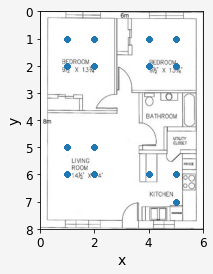

In [7]:
position = df.loc[:,['x', 'y']]
plotTrain(position,'minespark.jpg', width, height)

In [8]:
def createSortedMAC(data_frame):
    grouped_df = data_frame.groupby(by=['x','y'])
    # for key,item in grouped_df:
    #     a_group = grouped_df.get_group(key)
    #     print(a_group, "\n")
    sorted_mac = None
    filter_mac = None
    use_type = 'w'
    grid_sum = len(grouped_df.groups)
    if not sorted_mac:
        mac = set(data_frame[data_frame['type'] == use_type]['mac'].unique())
        sorted_mac = sorted(mac & filter_mac if filter_mac else mac)
    return sorted_mac

In [9]:
sorted_mac = createSortedMAC(df)

In [10]:
def process(data_frame, sorted_mac):
    grouped = data_frame.groupby(by=['grid_id'])
    grid_sum = len(grouped.groups)
    # cols = ['room', 'x', 'y']
    cols = ['room']
    cols.extend(sorted_mac)
    new_data_frame = pd.DataFrame(columns = cols,  index = range(grid_sum))
    grid_index = 0
    for name, group in grouped:
            for index, row in group.iterrows():
                if row['mac'] in sorted_mac:
                    new_data_frame.loc[grid_index, row['mac']] = row['rssi']                    
                    x, y = row['x'], row['y']
                    if x<=width/2:
                        if y <= height/2:
                            new_data_frame.loc[grid_index, 'room'] = 1
                        else:
                            new_data_frame.loc[grid_index, 'room'] = 2
                    else:
                        if y <= height/2:
                            new_data_frame.loc[grid_index, 'room'] = 3
                        else:
                            new_data_frame.loc[grid_index, 'room'] = 4
            grid_index += 1 
    return new_data_frame.sort_values(by = 'room')

In [11]:
train_df = process(df, sorted_mac)
train_df

,room,04:bd:88:76:f4:20,04:bd:88:76:f4:21,04:bd:88:76:f4:22,04:bd:88:76:f4:30,04:bd:88:76:f4:31,04:bd:88:76:f4:32,04:bd:88:76:f4:c0,04:bd:88:76:f4:c1,04:bd:88:76:f4:c2,04:bd:88:76:f5:80,04:bd:88:76:f5:81,04:bd:88:76:f5:82,04:bd:88:76:f5:90,04:bd:88:76:f5:91,04:bd:88:76:f5:92,04:bd:88:76:f6:82,04:bd:88:76:f6:e0,04:bd:88:76:f6:e2,04:bd:88:76:f7:20,04:bd:88:76:f7:21,04:bd:88:76:f7:22,04:bd:88:76:f7:30,04:bd:88:76:f7:32,04:bd:88:76:f9:e0,04:bd:88:76:f9:e1,04:bd:88:76:f9:e2,04:bd:88:76:f9:f0,04:bd:88:76:f9:f1,04:bd:88:76:f9:f2,04:bd:88:77:05:e2,04:bd:88:77:07:20,04:bd:88:77:07:21,04:bd:88:77:07:22,04:bd:88:77:07:62,04:bd:88:77:08:20,04:bd:88:77:08:21,04:bd:88:77:08:22,04:bd:88:77:08:30,04:bd:88:77:08:31,04:bd:88:77:08:32,12:d0:7a:c5:05:b5,18:64:72:29:09:c0,18:64:72:29:09:c1,18:64:72:29:09:c2,18:64:72:29:09:d0,18:64:72:29:09:d1,18:64:72:29:09:d2,3c:84:6a:81:e0:4b,62:45:b6:ce:ac:21,62:45:b7:78:a1:82,6c:f3:7f:7f:7c:c2,70:8b:cd:5e:4f:f0,84:d4:7e:4a:4a:e2,84:d4:7e:4a:68:00,84:d4:7e:4a:68:02,84:d4:7e:4a:6d:a2,84:d4:7e:4a:ae:80,84:d4:7e:4a:ae:81,84:d4:7e:4a:ae:82,84:d4:7e:4a:ce:82,84:d4:7e:4a:d1:e2,84:d4:7e:4a:d4:a0,84:d4:7e:4a:d4:a1,84:d4:7e:4a:d4:a2,86:2a:fd:60:d4:6f,98:e7:f4:45:9b:4a,a0:04:60:6c:92:94,d8:eb:97:ed:c8:36,fa:8f:ca:61:cc:1e,fe:f5:c4:82:95:d6
22,1,-72,-72,-69,-84,-85,-85,NaN,NaN,-87,-73,-73,-66,NaN,NaN,NaN,NaN,NaN,-75,-85,-84,-83,NaN,NaN,-43,-43,-44,-44,-44,-44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-87,-84,-85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-85,NaN,NaN,NaN,NaN
42,1,-89,-89,-89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-62,-62,-62,-68,-68,-69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-87,-88,-86,NaN,NaN,NaN,-92,NaN,NaN,NaN,NaN,NaN,-86,-89,-90,NaN,NaN,NaN,-85,NaN,-89,-90,NaN,NaN,NaN,NaN,-88,NaN,NaN
43,1,-89,-89,-89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-62,-62,-62,-68,-68,-69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-87,-88,-86,NaN,NaN,NaN,-92,NaN,NaN,NaN,NaN,NaN,-86,-89,-90,NaN,NaN,NaN,-85,NaN,-89,-90,NaN,NaN,NaN,NaN,-88,NaN,NaN
21,1,-72,-72,-69,-84,-85,-85,NaN,NaN,-87,-73,-73,-66,NaN,NaN,NaN,NaN,NaN,-75,-85,-84,-83,NaN,NaN,-43,-43,-44,-44,-44,-44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-87,-84,-85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-85,NaN,NaN,NaN,NaN
20,1,-72,-72,-69,-84,-85,-85,NaN,NaN,-87,-73,-73,-66,NaN,NaN,NaN,NaN,NaN,-75,-85,-84,-83,NaN,NaN,-43,-43,-44,-44,-44,-44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-87,-84,-85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-85,NaN,NaN,NaN,NaN
19,1,-72,-72,-69,-84,-85,-85,NaN,NaN,-87,-73,-73,-66,NaN,NaN,NaN,NaN,NaN,-75,-85,-84,-83,NaN,NaN,-43,-43,-44,-44,-44,-44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-87,-84,-85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-85,NaN,NaN,NaN,NaN
7,1,-77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-76,-78,-78,-83,-87,-87,-88,NaN,NaN,NaN,-86,NaN,-89,NaN,NaN,-48,-48,-50,-51,-50,-51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-87,NaN,NaN,NaN,NaN,-86,-86,-87,NaN,NaN,NaN,NaN,NaN,-76,NaN,-88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,1,-89,-89,-89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-62,-62,-62,-68,-68,-69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-87,-88,-86,NaN,NaN,NaN,-92,NaN,NaN,NaN,NaN,NaN,-86,-89,-90,NaN,NaN,NaN,-85,NaN,-89,-90,NaN,NaN,NaN,NaN,-88,NaN,NaN
6,1,-77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-76,-78,-78,-83,-87,-87,-88,NaN,NaN,NaN,-86,NaN,-89,NaN,NaN,-48,-48,-50,-51,-50,-51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-87,NaN,NaN,NaN,NaN,-86,-86,-87,NaN,NaN,NaN,NaN,NaN,-76,NaN,-88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,-77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-76,-78,-78,-83,-87,-87,-88,NaN,NaN,NaN,-86,NaN,-89,NaN,NaN,-48,-48,-50,-51,-50,-51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-87,NaN,NaN,NaN,NaN,-86

In [12]:

train_all_average = train_df.mean()
# train_all_average

In [13]:

for i in range(1,5):
    train_df.loc[train_df.room == i] = train_df.loc[train_df.room == i].fillna(train_df.loc[train_df.room == i].mean())
train_df

,room,04:bd:88:76:f4:20,04:bd:88:76:f4:21,04:bd:88:76:f4:22,04:bd:88:76:f4:30,04:bd:88:76:f4:31,04:bd:88:76:f4:32,04:bd:88:76:f4:c0,04:bd:88:76:f4:c1,04:bd:88:76:f4:c2,04:bd:88:76:f5:80,04:bd:88:76:f5:81,04:bd:88:76:f5:82,04:bd:88:76:f5:90,04:bd:88:76:f5:91,04:bd:88:76:f5:92,04:bd:88:76:f6:82,04:bd:88:76:f6:e0,04:bd:88:76:f6:e2,04:bd:88:76:f7:20,04:bd:88:76:f7:21,04:bd:88:76:f7:22,04:bd:88:76:f7:30,04:bd:88:76:f7:32,04:bd:88:76:f9:e0,04:bd:88:76:f9:e1,04:bd:88:76:f9:e2,04:bd:88:76:f9:f0,04:bd:88:76:f9:f1,04:bd:88:76:f9:f2,04:bd:88:77:05:e2,04:bd:88:77:07:20,04:bd:88:77:07:21,04:bd:88:77:07:22,04:bd:88:77:07:62,04:bd:88:77:08:20,04:bd:88:77:08:21,04:bd:88:77:08:22,04:bd:88:77:08:30,04:bd:88:77:08:31,04:bd:88:77:08:32,12:d0:7a:c5:05:b5,18:64:72:29:09:c0,18:64:72:29:09:c1,18:64:72:29:09:c2,18:64:72:29:09:d0,18:64:72:29:09:d1,18:64:72:29:09:d2,3c:84:6a:81:e0:4b,62:45:b6:ce:ac:21,62:45:b7:78:a1:82,6c:f3:7f:7f:7c:c2,70:8b:cd:5e:4f:f0,84:d4:7e:4a:4a:e2,84:d4:7e:4a:68:00,84:d4:7e:4a:68:02,84:d4:7e:4a:6d:a2,84:d4:7e:4a:ae:80,84:d4:7e:4a:ae:81,84:d4:7e:4a:ae:82,84:d4:7e:4a:ce:82,84:d4:7e:4a:d1:e2,84:d4:7e:4a:d4:a0,84:d4:7e:4a:d4:a1,84:d4:7e:4a:d4:a2,86:2a:fd:60:d4:6f,98:e7:f4:45:9b:4a,a0:04:60:6c:92:94,d8:eb:97:ed:c8:36,fa:8f:ca:61:cc:1e,fe:f5:c4:82:95:d6
22,1,-72,-72,-69,-84,-85,-85,NaN,NaN,-87,-73,-73,-66,-87,-87,-88,NaN,NaN,-75,-85,-84,-83,NaN,NaN,-43,-43,-44,-44,-44,-44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-87,NaN,NaN,NaN,NaN,-87,-84,-85,NaN,NaN,NaN,-92,NaN,-76,NaN,-82,NaN,-86,-89,-90,NaN,NaN,NaN,-85,NaN,-89,-90,NaN,NaN,-85,NaN,-88,NaN,NaN
42,1,-89,-89,-89,-84,-85,-85,NaN,NaN,-81.5,-75.5,-75.5,-74.5,-87,-87,-88,NaN,NaN,-75,-85.5,-84,-86,NaN,NaN,-62,-62,-62,-68,-68,-69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-87,NaN,NaN,NaN,NaN,-87,-88,-86,NaN,NaN,NaN,-92,NaN,-76,NaN,-85,NaN,-86,-89,-90,NaN,NaN,NaN,-85,NaN,-89,-90,NaN,NaN,-85,NaN,-88,NaN,NaN
43,1,-89,-89,-89,-84,-85,-85,NaN,NaN,-81.5,-75.5,-75.5,-74.5,-87,-87,-88,NaN,NaN,-75,-85.5,-84,-86,NaN,NaN,-62,-62,-62,-68,-68,-69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-87,NaN,NaN,NaN,NaN,-87,-88,-86,NaN,NaN,NaN,-92,NaN,-76,NaN,-85,NaN,-86,-89,-90,NaN,NaN,NaN,-85,NaN,-89,-90,NaN,NaN,-85,NaN,-88,NaN,NaN
21,1,-72,-72,-69,-84,-85,-85,NaN,NaN,-87,-73,-73,-66,-87,-87,-88,NaN,NaN,-75,-85,-84,-83,NaN,NaN,-43,-43,-44,-44,-44,-44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-87,NaN,NaN,NaN,NaN,-87,-84,-85,NaN,NaN,NaN,-92,NaN,-76,NaN,-82,NaN,-86,-89,-90,NaN,NaN,NaN,-85,NaN,-89,-90,NaN,NaN,-85,NaN,-88,NaN,NaN
20,1,-72,-72,-69,-84,-85,-85,NaN,NaN,-87,-73,-73,-66,-87,-87,-88,NaN,NaN,-75,-85,-84,-83,NaN,NaN,-43,-43,-44,-44,-44,-44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-87,NaN,NaN,NaN,NaN,-87,-84,-85,NaN,NaN,NaN,-92,NaN,-76,NaN,-82,NaN,-86,-89,-90,NaN,NaN,NaN,-85,NaN,-89,-90,NaN,NaN,-85,NaN,-88,NaN,NaN
19,1,-72,-72,-69,-84,-85,-85,NaN,NaN,-87,-73,-73,-66,-87,-87,-88,NaN,NaN,-75,-85,-84,-83,NaN,NaN,-43,-43,-44,-44,-44,-44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-87,NaN,NaN,NaN,NaN,-87,-84,-85,NaN,NaN,NaN,-92,NaN,-76,NaN,-82,NaN,-86,-89,-90,NaN,NaN,NaN,-85,NaN,-89,-90,NaN,NaN,-85,NaN,-88,NaN,NaN
7,1,-77,-79.2857,-77.5714,-84,-85,-85,NaN,NaN,-76,-78,-78,-83,-87,-87,-88,NaN,NaN,-75,-86,-84,-89,NaN,NaN,-48,-48,-50,-51,-50,-51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-87,NaN,NaN,NaN,NaN,-86,-86,-87,NaN,NaN,NaN,-92,NaN,-76,NaN,-88,NaN,-86,-89,-90,NaN,NaN,NaN,-85,NaN,-89,-90,NaN,NaN,-85,NaN,-88,NaN,NaN
44,1,-89,-89,-89,-84,-85,-85,NaN,NaN,-81.5,-75.5,-75.5,-74.5,-87,-87,-88,NaN,NaN,-75,-85.5,-84,-86,NaN,NaN,-62,-62,-62,-68,-68,-69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-87,NaN,NaN,NaN,NaN,-87,-88,-86,NaN,NaN,NaN,-92,NaN,-76,NaN,-85,NaN,-86,-89,-90,NaN,NaN,NaN,-85,NaN,-89,-90,NaN,NaN,-85,NaN,-88,NaN,NaN
6,1,-77,-79.2857,-77.5714,-84,-85,-85,NaN,NaN,-76,-78,-78,-83,-87,-87,-88,NaN,NaN,-75,-86,-84,-89,NaN,NaN,-48,-48,-50,-51,-50,-51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-87,NaN,NaN,NaN,NaN,-86,-86,-87,NaN,NaN,NaN,-92,NaN,-76,NaN,-88,NaN,-86,-89,-90,NaN,NaN,NaN,-85,NaN,-89,-90,NaN,NaN,-85,NaN,-88,NaN,NaN
4,1,-77,-79.2857,-77.5714,-84,-85,-85,NaN,NaN,-76,-78,-78,-83,-87,-87,-88,NaN,NaN,-75,-86,-84,-89,NaN,NaN,-48,-48,-50,-51

In [14]:
train_df = train_df.fillna(-100)

In [15]:
from sklearn.svm import SVC
svm_clf = SVC()

In [16]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)

In [17]:
from sklearn.model_selection import cross_val_predict, cross_val_score
# train_df.info()
featureStart = 1
featureEnd = 35
features = train_df.iloc[:, featureStart:featureEnd].to_numpy()
# features
train_truth = train_df['room']

# classifier = svm_clf
classifier = knn
train_predict = cross_val_predict(classifier, features, train_truth, method='predict', cv=3)
score = cross_val_score(classifier, features, train_truth, scoring='neg_root_mean_squared_error', cv=3)
score

array([-0.        , -1.03279556, -1.03279556])

In [18]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    """Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

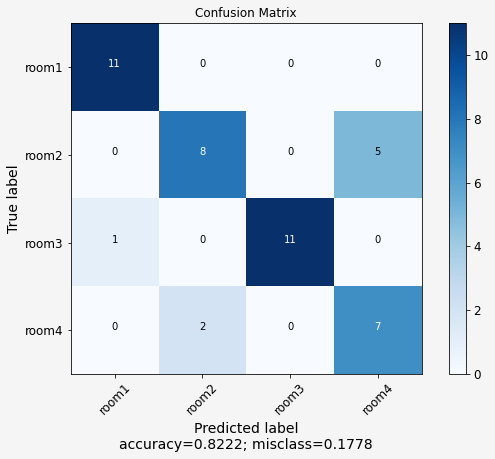

In [19]:
conf_mx = confusion_matrix(train_truth, train_predict)
plot_confusion_matrix(cm           = conf_mx, 
                      normalize    = False,
                      target_names = ['room' + str(i) for i in range(1,5)],
                      title        = "Confusion Matrix")

KNeighborsClassifier(n_neighbors=3)

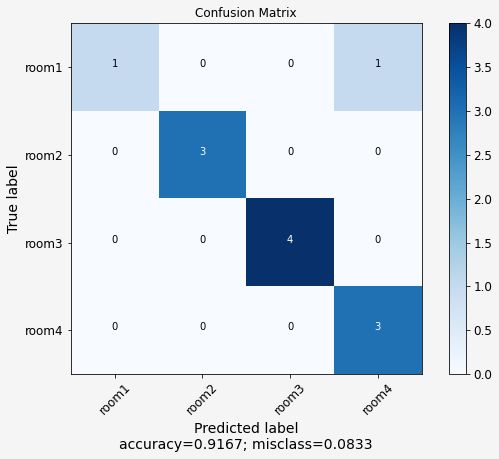

In [20]:
test_df_raw = txtToDataFrame('test11_19.txt')
test_df = process(test_df_raw, sorted_mac)
test_df = test_df.fillna(train_df.mean())
x_test = test_df.iloc[:, featureStart:featureEnd]
y_test = test_df['room']
# x_test, y_test = features, train_truth

classifier.fit(features, train_truth)
y_predict = classifier.predict(x_test)
conf_mx = confusion_matrix(y_test, y_predict)
plot_confusion_matrix(cm           = conf_mx, 
                      normalize    = False,
                      target_names = ['room' + str(i) for i in range(1,5)],
                      title        = "Confusion Matrix")
